In [1]:
import sys
import os
sys.path.append(os.path.abspath("../"))  # or "../../" depending on location

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from utils.likelihood import *
from utils.formate_matrix_toMLData import *
from models.model_0728 import *
import matplotlib.pyplot as plt
import japanize_matplotlib
plt.rcParams["font.size"] = 22
np.set_printoptions(suppress=True)


In [3]:
# load virtual data
# data_dir = "../datas/for_uniform"
test_states = []
test_del_t = []
test_targets = []
dataset = []
formater = formate_dataMatrix()

# 読み込む対象の拡張子（例: .csv のみに限定）
VALID_EXTENSIONS = (".csv", ".txt")
IGNORED_PREFIXES = ("._", ".DS_Store", "Thumbs.db")

# ファイルを処理する関数
def process_file(file_path):
    try:
        print("Processing:", file_path)
        with open(file_path, 'rb') as f:
            all_matrix = np.loadtxt(f, delimiter=",")

        tm = matrix_trimer(all_matrix)
        trm = tm.trim_transitionRateMatrix()
        data = tm.trim_data()
        output_vec = np.array(formater.GetOutputVector_byDiagonal(trm))

        # state: shape (2, num_samples_i)
        state = np.stack([data[:, 0], data[:, 1]], axis=0)
        test_states.append(state)
        test_del_t.append(data[:, 2])
        test_targets.append(output_vec)

    except Exception as e:
        print(f"❌ Skipping file: {file_path} (Reason: {e})")

# ディレクトリ内のファイルを一括処理
def process_all_files_in_directory(directory, func):
    for filename in os.listdir(directory):
        if filename.startswith(IGNORED_PREFIXES):
            continue
        if not filename.endswith(VALID_EXTENSIONS):
            continue

        file_path = os.path.join(directory, filename)
        if os.path.isfile(file_path):
            func(file_path)

# 実行
process_all_files_in_directory("/Volumes/TRANSCEND/datas/test_data", process_file)



# データセットとデータローダーの作成
test_dataset = varSets_Datasets(test_states, test_del_t, test_targets)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
data_iter = iter(test_dataloader)

Processing: /Volumes/TRANSCEND/datas/test_data/0_20000_4.csv
Processing: /Volumes/TRANSCEND/datas/test_data/1_20000_4.csv
Processing: /Volumes/TRANSCEND/datas/test_data/2_20000_4.csv
Processing: /Volumes/TRANSCEND/datas/test_data/3_20000_4.csv
Processing: /Volumes/TRANSCEND/datas/test_data/4_20000_4.csv
Processing: /Volumes/TRANSCEND/datas/test_data/5_20000_4.csv
Processing: /Volumes/TRANSCEND/datas/test_data/6_20000_4.csv
Processing: /Volumes/TRANSCEND/datas/test_data/7_20000_4.csv
Processing: /Volumes/TRANSCEND/datas/test_data/8_20000_4.csv
Processing: /Volumes/TRANSCEND/datas/test_data/9_20000_4.csv
Processing: /Volumes/TRANSCEND/datas/test_data/10_20000_4.csv
Processing: /Volumes/TRANSCEND/datas/test_data/11_20000_4.csv
Processing: /Volumes/TRANSCEND/datas/test_data/12_20000_4.csv
Processing: /Volumes/TRANSCEND/datas/test_data/13_20000_4.csv
Processing: /Volumes/TRANSCEND/datas/test_data/14_20000_4.csv
Processing: /Volumes/TRANSCEND/datas/test_data/15_20000_4.csv
Processing: /Volum

In [4]:
device = torch.device("cpu")
model = DeepSets_varSets_forDiagnel(device=device)
model.load_state_dict(torch.load("../model_weights/mixed_distribution/mixed_0728.pth"))
model.eval()

/var/folders/k3/b1t1gjg12pg0ycfdgpm2k7g00000gn/T/ipykernel_95387/3962693643.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../model_we

DeepSets_varSets_forDiagnel(
  (embedding): Embedding(4, 2)
  (fc1): Linear(in_features=5, out_features=32, bias=True)
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (att_fc): Linear(in_features=64, out_features=64, bias=True)
  (att_score): Linear(in_features=64, out_features=1, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (dropout3): Dropout(p=0.3, inplace=False)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (dropout4): Dropout(p=0.1, inplace=False)
  (fc5): Linear(in_features=32, out_features=3, bias=True)
)

In [5]:
loss_list = []
outs_lifespan = []
true_lifespan = []
class all_lifespan_loss(nn.Module):
    def forward(self, outputs, targets):
        epsilon = 1e-12
        y_pred_inverse = 1.0 / (outputs )
        y_true_inverse = 1.0 / (targets )
        
        # 逆数の差の絶対値
        loss_tensor = torch.abs(y_pred_inverse - y_true_inverse)[0]
        return loss_tensor, y_true_inverse[0], y_pred_inverse
criterion = all_lifespan_loss()

for a, b, c,d in data_iter:
    with torch.no_grad():
        out = model(a, b, d)[0]
        loss, true_expect ,pred_expect= criterion(out,c)
        
        for i in range(3):
            true_lifespan.append(true_expect[i].item())
            outs_lifespan.append(pred_expect[i].item())

df = pd.DataFrame()
df["true"] = true_lifespan
df["pred"] = outs_lifespan
df["loss"] = (df["true"] - df["pred"]).abs()


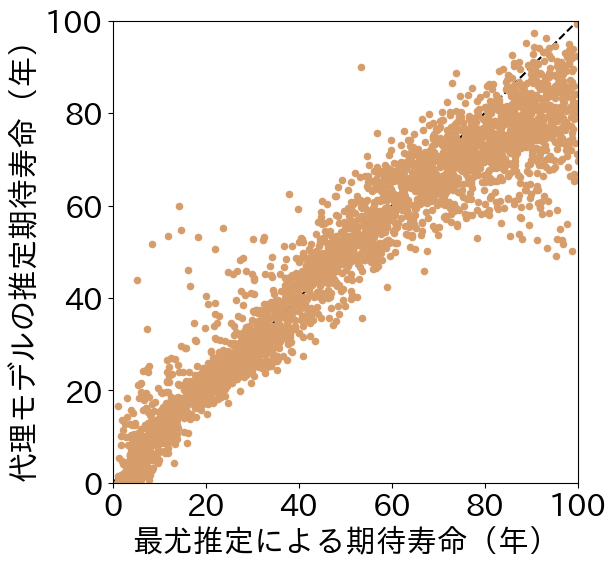

In [6]:
plt.figure(figsize=(6,6))
x = np.linspace(0, 100, 1000)

plt.xlim(0,100)
plt.ylim(0,100)
plt.xlabel("最尤推定による期待寿命（年）")
plt.ylabel("代理モデルの推定期待寿命（年）")
plt.plot(x,x,color="#000000", linestyle = '--',zorder= 0)
plt.scatter(df["true"],df["pred"],color = "#d69c6a",edgecolors="#d79e6b",s = 20,  zorder= 1)


5412


Text(0.5, 1.0, 'RC床版の点検間隔分布')

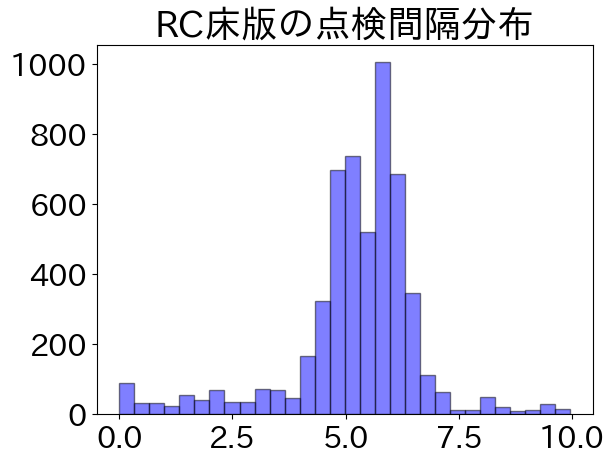

In [7]:
real_data_dir = "../real_data/data.csv"
df = pd.read_csv(real_data_dir, delimiter=",", header = None)
df.columns = ["pre", "post", "time"]
df = df[df["pre"] < 4]
df = df[df["post"] < 5]
print(len(df))
r = 1.2
plt.hist(df["time"], bins=30, alpha=0.5, color="blue", edgecolor="black", zorder= 2)
plt.title("RC床版の点検間隔分布")

In [8]:
colors= ['#6b89a9', '#8ea978', '#d69c6a', '#a55a5b'] #彩度下げ冷暖色
plt.rcParams["figure.figsize"] = (8, 5)

sequence = np.arange(0, 100, 0.01)
def visualize(Q,title):
    vecs = []
    for t in sequence:
        P = expm(Q * t)
        vecs.append(P[0])
    
    for i, vec in enumerate(vecs):
        bottom = 0
        # vec = vec[::-1]
    
        for j, value in enumerate(vec):
            plt.bar(sequence[i], value, bottom=bottom, color=colors[j],width=0.01)
            bottom += value
    for i in range(len(colors)):
        plt.scatter([],[], color = colors[i],label = f"Condition state {i+1}")
    vecs = np.array(vecs)
    
    plot_trueline(c[0])
    plt.tick_params(axis='x', labelsize=14, direction='in', length=10)
    plt.tick_params(axis='y', labelsize=14, direction='in', length=10)
    plt.xlabel("Elapsed time (year)", fontsize = 22)
    plt.ylabel("Ratio", fontsize = 22)
    # plt.title(title, fontsize = 18)
    plt.legend(loc = "lower left")
    plt.show()
    
def generate_Q_from_diagonal(vec):
        Q = np.zeros((4,4))
        for i in range(len(vec)):
            Q[i,i+1]= vec[i]
            Q[i,i] = -Q[i,i+1]
        return Q
def plot_trueline(vec):
    true_vecs = []
    true_Q = generate_Q_from_diagonal(vec/r)
    for t in sequence:
        P = expm(true_Q * t)
        true_vecs.append(P[0])
    true_vecs = np.array(true_vecs)
    
    plt.plot(sequence,true_vecs[:,0],linestyle = "--",color = "black",lw = 4)
    plt.plot(sequence,true_vecs[:,0]+true_vecs[:,1],linestyle = "-.",color = "black",lw = 4)
    plt.plot(sequence,true_vecs[:,0]+true_vecs[:,1]+true_vecs[:,2],linestyle = ":",color = "black",lw = 4)
    

print("代理モデルによる劣化推移予測")
visualize(generate_Q_from_diagonal(out[0]/r),"代理モデルによる劣化推移予測")

代理モデルによる劣化推移予測


TypeError: len() of a 0-d tensor